# Anomaly Detection in Network Connections

## Goal
 Detect connections that do not resemble connections that have been observed in the past. Such connections can potentially be from the attackers using unknown attacking methodologies.


## Data
- The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. 
- Each connection is one line of CSV-formatted data, containing **38 features**: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

- Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## Detection Methodology
We will be using **KNN algorithm** for clustering connections.

## Clustering without Using Categorical Features
We will be ignoring following categorical features:
- protocol type
- service
- flag

### Imports

In [ ]:
!pip install pyspark
import os
import sys
import re
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("anomaly-detection").setMaster("local[*]")
sc = SparkContext(conf=conf)

from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel
from operator import add
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 60.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=e438b08955a171c3ce798be72fd968541f0db75331bf0956e39ae3259bc32dff
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


### Loading data

In [ ]:
# upload file to colab
from google.colab import files
uploaded = files.upload()

Saving kddcup.data.gz to kddcup.data.gz


In [ ]:
# extract zip file
!gzip -d "/content/kddcup.data.gz"

In [ ]:
# read data
input_path = "/content/kddcup.data"
raw_data = sc.textFile(input_path, 12)

### Extract Numerical Features

In [ ]:
def parseLine(line):
  """
    returns (label, vector)
    Here, 
    label: groundtruth label for each connection
    vector: array of all numerical features 
  """
  cols = line.split(",")
  # label is the last column
  label = cols[-1]

  # vector is every column, except the label
  vector = cols[:-1]

  # we need only numerical features
  # delete values of columns that have index 1->3 (categorical features)
  vector = [x for i, x in enumerate(vector) if i not in [1, 2, 3]]

  # convert each value from string to float
  vector = np.array(vector, dtype=np.float)

  return (label, vector)

labelsAndData = raw_data.map(parseLine).cache()

# extract features, we only need the data, not the label
data = labelsAndData.map(lambda x : x[1]).cache()

# number of connections
n = data.count()

### Explore Data

In [ ]:
print("Number of connections:", n)
print("Details per connection:", len(data.first()))

Number of connections: 4898431
Details per connection: 38


In [ ]:
x = labelsAndData.map(lambda x: x[0]).distinct().count()
print("Total number of labels:\n", x)
y = labelsAndData.map(lambda x : (x[0], 1)).reduceByKey(add).collect()

Total number of labels:
 23


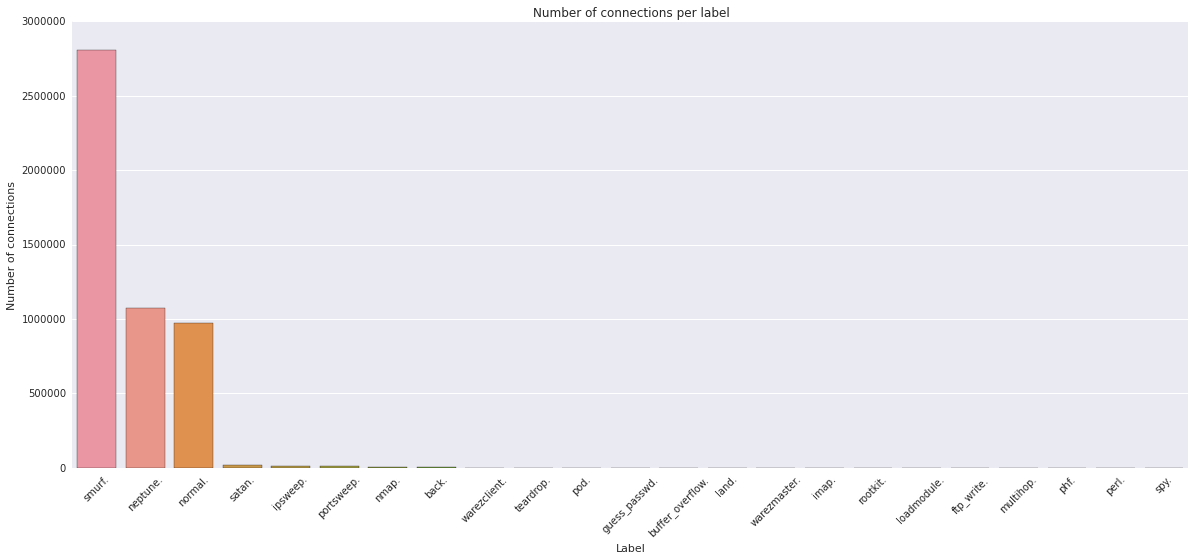

In [ ]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

In [ ]:
# amount of connections of the first 3 labels.
print("amount of connections of the first 3 labels:\t", y[0][1]+y[1][1]+y[2][1])

amount of connections of the first 3 labels:	 4852684


### Conclusion about Distribution of Dataset Labels

- There are 23 different labels but data is not equally divided.
- Of the nearly 5 million connections, more than a half (>2.5 million) are labelled as <i>smurf</i> and other 2 millions are equally divided as <i>neptune</i> and <i>normal</i>
- As we can see, of the 4898431, 4852684 are dedicated to just 3 labels leaving less than 40 thousand connections to the remaining 20 labels.
- This initial look inside the data may hint us on how the data is divided in the space: since so much data has the same label, probably it will be packed up together and leave all the other labels as "outliers".

### Clustering into 2 Groups using MLlib

In [ ]:
clusters = KMeans.train(data, 2, maxIterations=10, runs=10, initializationMode="random")

Each connection has 38 attributes. If we want to cluster the data we have to decide which are the best features to use on the axis to plot the data. For this first example, let's simply use the first 3 features to do a 3D plot.

Let's first see how the data is divided.

In [ ]:
from operator import add

__ = labelsAndData.map(lambda x : (clusters.predict(x[1]), 1)).reduceByKey(add).collect()
for _ in __:
    print("Cluster %5d\tNumber of elements: %10d" %(_[0], _[1]))

Cluster     0	Number of elements:          5
Cluster     1	Number of elements:    4898426


**Observations from multiple tests:** 
- After first training session, we got the 5 million connections divided almost equally
- The second time we got all connections but 5 in one cluster and 5 connections of label "portsweep" in the second cluster
- While the third time we have all connections in one cluster and none in the second one.

**Conclusion:**
- Clustering depends on centroid initializations
- Curse of dimensionality that can be the explanation of the random results we get; the majority of the data is stuck together and goes inside the same cluster.

### Visualizing Features in 3-D Cube
This may help with feature selection.

<div class="alert alert-success">
First of all we get the values of the 3 axis, and then we scatter the plots. We will not plot all of the 4 million connections but only a subset of those.
<br><br>
As of now, we will just use the first 3 attributes as the first axis.
</div>

In [ ]:
sampled = data.sample(withReplacement=False, fraction=0.01)
datax = sampled.map(lambda x: x[0]).collect()
datay = sampled.map(lambda x: x[1]).collect()
dataz = sampled.map(lambda x: x[2]).collect()
labels_ = sampled.map(lambda x: clusters.predict(x)).collect()

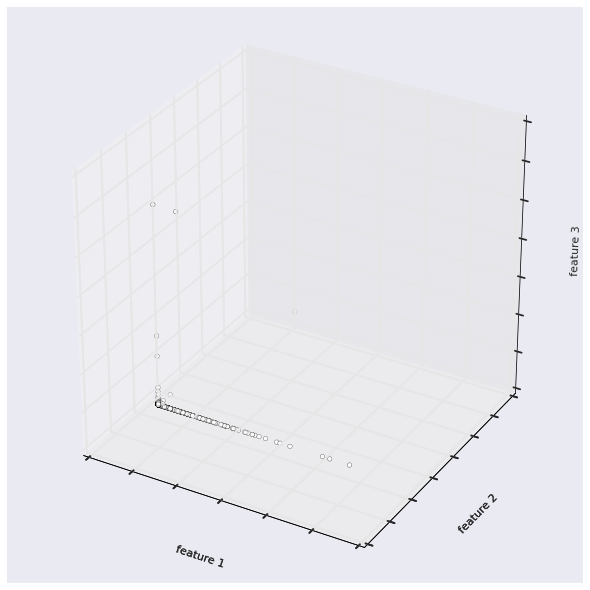

In [ ]:
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter(datax, datay, dataz, c=labels_)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

- Feature 2 is almost the same for every point and so maybe this feature doesn't contain much information.
- A good technique to get the best features and to understand how much of the information is contained in them is to use PCA.

### Principal Component Analysis
To find minimum number of features required to represent the information in the dataset.

In [ ]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import PCA as PCAmllib

vectorData = data.map(Vectors.dense)
PCAModel3 = PCAmllib(3).fit(vectorData)
pcaData3 = PCAModel3.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

PCAModel2 = PCAmllib(2).fit(vectorData)
pcaData2 = PCAModel2.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

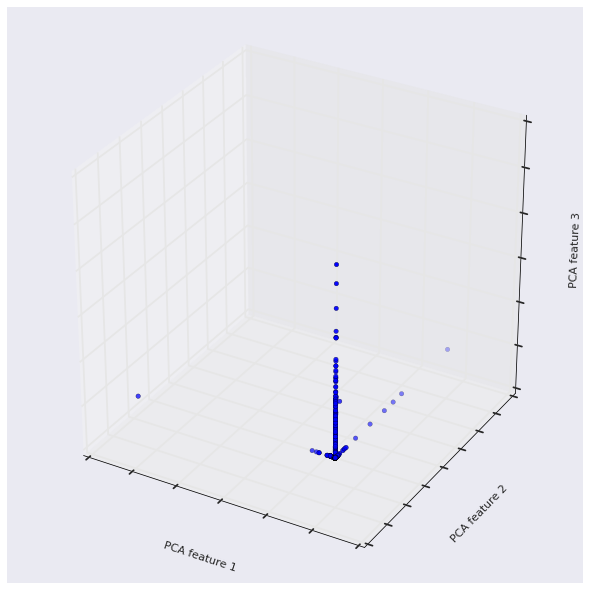

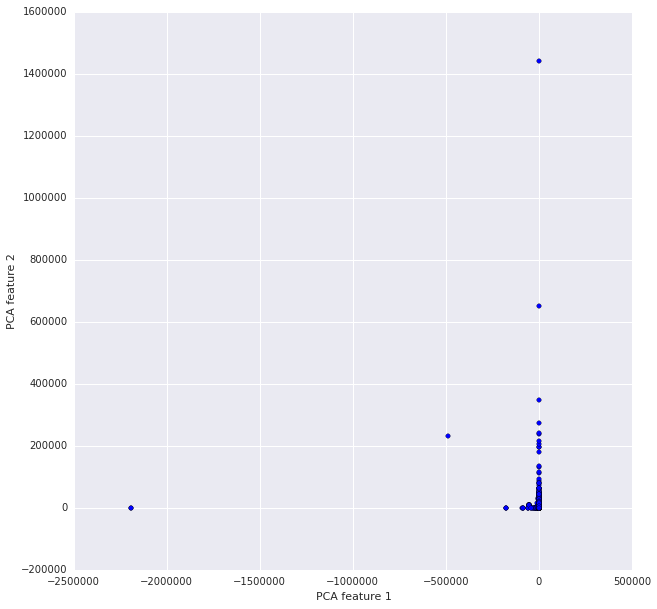

In [ ]:
#pca plot
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig)

ax.scatter([x[0] for x in pcaData3], [x[1] for x in pcaData3], [x[2] for x in pcaData3])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')
plt.show()

fig = plt.figure(1, figsize=(10, 10))

plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')

plt.show()

**Observations**
- Majority of data lies on 2 axes. So, 2 principal components are enough to summarize the information in dataset. Plus, we can confirm that data is closely packed.

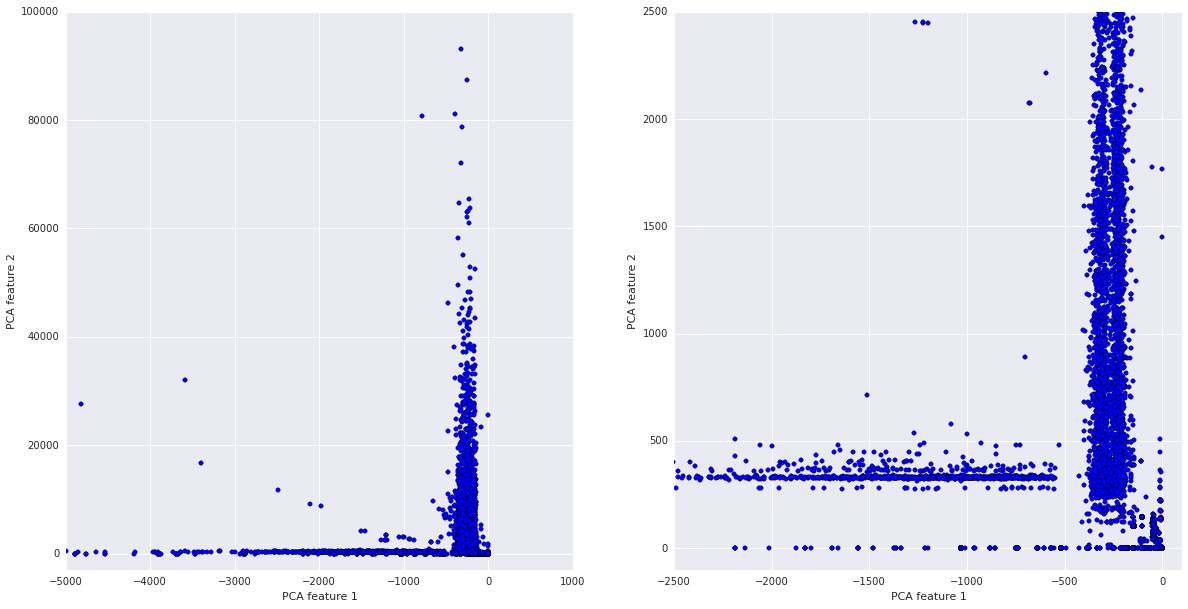

In [ ]:
fig = plt.figure(1, figsize=(20, 10))
plt.subplot(121)
plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.xlim(-5000,1000)
plt.ylim(-3000, 100000)

plt.subplot(122)
plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.xlim(-2500,100)
plt.ylim(-100, 2500)
plt.show()

**Observations**
- This plot shows better the effectiveness of the PCA. All of the data is compressed in the previous plot because there are some points with a much higher value in those dimensions that make all the data shrink together. 
- Zooming in, we can see that the majority of the points span in a small contour of the dimensions.

### Calculating Explained Variance

In [ ]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.sql import SQLContext
from pyspark.ml.linalg import Vectors
sqlContext = SQLContext(sc)
 
def make_it_work(array): #dummy function because Vectors.dense(array) would arise errors.
    return (Vectors.dense(array),)
 
vectorData = data.map(make_it_work)
df = sqlContext.createDataFrame(v_data,["features"]) #for the pca with this library we have to use a dataframe
pca = PCAml(k=3, inputCol="features", outputCol="pca_features")
model = pca.fit(df)
model.explainedVariance

DenseVector([0.6805, 0.3195, 0.0])

### Evaluating model

##### Using Within Set Sum of Squared Errors (WSSSE)

In [ ]:
def euclidean_distance(a, b, sqrt=True):
    if type(a) is not np.ndarray:
        a = np.array(a)
    if type(b) is not np.ndarray:
        b = np.array(b)
    c = a - b
    if sqrt is False:
        return c.T.dot(c)
    return np.sqrt(c.T.dot(c))

In [ ]:
import time

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(closest_center, point, sqrt=False)

In [ ]:
t1 = time.time()
print(clusters.computeCost(data))
print("Time needed:", time.time()-t1)

3.0525489575482665e+18
Time needed: 5.279970645904541


#### Find Label Counts for Each Cluster 

In [ ]:
clusterLabelCount = labelsAndData.map(lambda x : ((clusters.predict(x[1]), x[0]), 1)).reduceByKey(add).collect()

for item in clusterLabelCount:
    print("Label #%d\tClass:%20s\tOccurrences:%10d" %(item[0][0],item[0][1],item[1]))

Label #1	Class:               back.	Occurrences:      2203
Label #1	Class:               imap.	Occurrences:        12
Label #1	Class:           teardrop.	Occurrences:       979
Label #1	Class:                pod.	Occurrences:       264
Label #1	Class:              satan.	Occurrences:     15892
Label #1	Class:               land.	Occurrences:        21
Label #1	Class:          portsweep.	Occurrences:     10408
Label #1	Class:       guess_passwd.	Occurrences:        53
Label #1	Class:           multihop.	Occurrences:         7
Label #1	Class:            neptune.	Occurrences:   1072017
Label #1	Class:              smurf.	Occurrences:   2807886
Label #1	Class:             normal.	Occurrences:    972781
Label #1	Class:               nmap.	Occurrences:      2316
Label #1	Class:        warezmaster.	Occurrences:        20
Label #1	Class:                phf.	Occurrences:         4
Label #1	Class:                spy.	Occurrences:         2
Label #1	Class:         loadmodule.	Occurrences:        

In [ ]:
nrLabelsPerCluster = labelsAndData.map(lambda x : (clusters.predict(x[1]), x[0])).groupByKey().collect()
for _ in nrLabelsPerCluster:
    print("Cluster %5d\tNumber of classes: %10d" %(_[0], len(np.unique(_[1].data))))

Cluster     0	Number of classes:          1
Cluster     1	Number of classes:         23


**Observations**:
- One cluster usually gets almost all the classes while the other one gets 1 (portsweep)
- The clusters are heavily unbalanced due to the disparity of the whole dataset and this tells us one important thing: that the majority of the points are stuck together and there is a really small amount of outliers (only 5 were recognized). There are surely more than **5 outliers** but they hide for sure inside the first cluster.

**How can we uncover more outliers?**

The choice of k=2 could be better adapted; since there are 23 classes, it would make much more sense to use k=23 or more.


### Finding Better K Value for Clustering
#### Plotting Loss for Various K Values

In [ ]:
# k: the number of clusters
def clusteringScore(data, k, withCenters=False):
    clusters = KMeans.train(data, k, maxIterations=10, runs=10, initializationMode="random")
    # calculate mean square error
    if withCenters is True:
        return (clusters.computeCost(data), len(clusters.centers))
    return clusters.computeCost(data)

In [ ]:
k_vector = [2,5,10,23,30,50,70,100,120,200,300,400]

scores = [clusteringScore(data, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =   2, (effective nr. of clusters =   2) WSSSE = 3052548957548266496
k =   5, (effective nr. of clusters =   5) WSSSE = 1154456223993177600
k =  10, (effective nr. of clusters =   5) WSSSE = 1162421760546891520
k =  23, (effective nr. of clusters =  16) WSSSE = 994285071487709440
k =  30, (effective nr. of clusters =  19) WSSSE = 994224338793713408
k =  50, (effective nr. of clusters =  28) WSSSE = 1092446662800909440
k =  70, (effective nr. of clusters =  43) WSSSE = 966005455499744384
k = 100, (effective nr. of clusters =  46) WSSSE = 966022222212252800
k = 120, (effective nr. of clusters =  63) WSSSE = 990491690309865856
k = 200, (effective nr. of clusters =  93) WSSSE = 965993316209542656
k = 300, (effective nr. of clusters = 145) WSSSE = 965939323277659136
k = 400, (effective nr. of clusters = 198) WSSSE = 965942746630343808


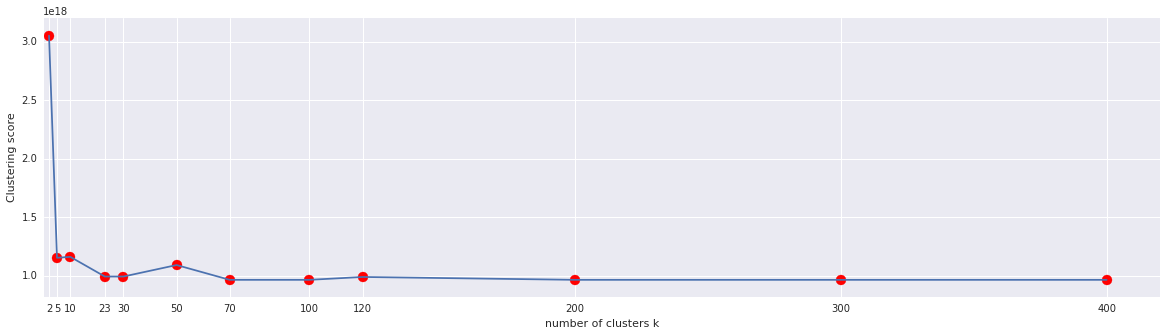

In [ ]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([0, np.max(k_vector)*1.05, 0.85*np.min(_), 1.05*np.max(_)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.xticks(k_vector)
plt.show()

**Observations:**
- We tried a different increasing number of clusters and we plotted the results above.

- The plot shows us that the initial choice of k=2 was absolutely nonsense being that the clustering score is really high with respect to the rest of the tests. Afterwards, with k=5, we have a huge drop when we test the KMeans. From k=23 onwards, the clustering score doesn't decrease anymore in a consistent way and so going further than 23 clusters doesn't seem to be a good choice.
This actually makes sense if we think about the data we are clustering: we have 23 different labels but actually many of them are pretty similiar and with similiar attributes and so when we use less clusters, they still stay packed together and increasing the clusters will just make more clusters really near to each other not improving the clustering score.

- Other than simply looking at the plot, another more methodological solution could have been to apply the <a href="http://erikerlandson.github.io/blog/2016/08/03/x-medoids-using-minimum-description-length-to-identify-the-k-in-k-medoids/">Minimum Description Length Principle</a> that tries to find the best optimization for k.
</div>

#### Plot Effective K Value for Each K
**What is effective k value or effective number of clusters?**

When the kmeans algorithm runs, the various points change cluster as the centers get updated. If, after reassigning the points, one of the cluster becomes empty, it is deleted from the list of clusters.

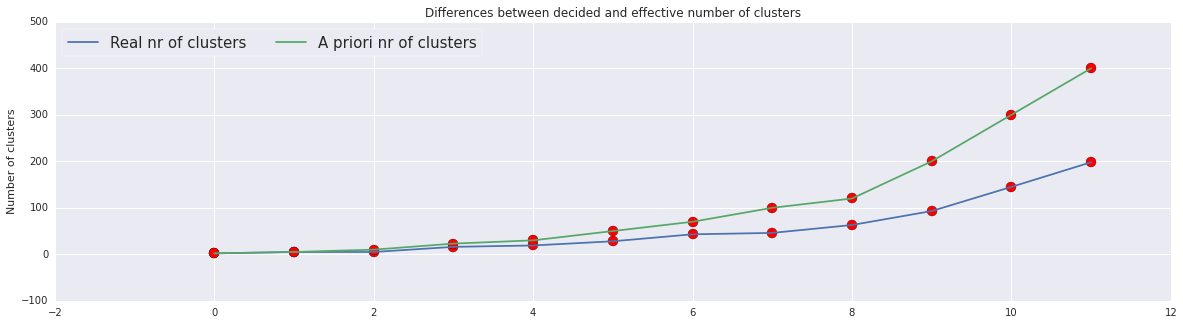

In [ ]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

**Observations**
- As we increase the number of clusters, the effective number of clusters doesn't increase with the same pace and this is why the clustering. The trend is that after 20 clusters, approximately half of the desired clusters get deleted. We can see this from the slope and also from the detailed numbers in the printing above that:
<ul>
<li>30 drops to 11
<li>50 -> 26
<li>70 -> 38
<li>100 -> 48
<li>120 -> 60
<li>...
<li>400 -> 190
</ul>
</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


In [ ]:
def normalizeData(labelsAndData):
     # calculate means
    means = labelsAndData.map(lambda x:x[1]).mean()
    # calculate standard deviation of each feature
    stdevs = np.sqrt(labelsAndData.map(lambda x : (x[1]-means)**2).mean())
    
    stdevs[stdevs==0] = 1
    def normalize(point):
        return (point[0],(point[1]-means)/stdevs)

    return labelsAndData.map(lambda x: normalize(x))

labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x: x[1]).cache()
print(normalizedData.take(5))

[array([ -6.68331854e-02,  -1.72038228e-03,   6.81884351e-02,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-03,  -4.54646139e-03,
        -3.28458917e-03,  -9.57233922e-03,  -8.50457842e-03,
        -2.87561127e-02,   0.00000000e+00,  -6.38979005e-04,
        -2.89113034e-02,  -1.57541507e+00,  -1.19624324e+00,
        -4.66042614e-01,  -4.65755574e-01,  -2.48285775e-01,
        -2.48130352e-01,   5.39733093e-01,  -2.56056520e-01,
        -2.01059296e-01,  -3.63913926e+00,  -1.78651044e+00,
        -1.83302273e+00,  -2.82939000e-01,  -1.25793664e+00,
        -1.56668488e-01,  -4.66404784e-01,  -4.65453641e-01,
        -2.50831829e-01,  -2.49631966e-01]), array([ -6.68331854e-02,  -1.77667956e-03,   5.32451452e-03,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-

### Find Best K Value for Normalized Data

Using the new data, we will build different models with different values of $k \in [60,70,80,90,100,110]$. We wll Evaluate the results by plotting them and choose the best value of $k$.

</div>

In [ ]:
k_vector = [60,70,80,90,100,110]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =  60, (effective nr. of clusters =  30) WSSSE = 71907910
k =  70, (effective nr. of clusters =  37) WSSSE = 66333959
k =  80, (effective nr. of clusters =  39) WSSSE = 66426038
k =  90, (effective nr. of clusters =  51) WSSSE = 71016365
k = 100, (effective nr. of clusters =  53) WSSSE = 59803588
k = 110, (effective nr. of clusters =  56) WSSSE = 55318890


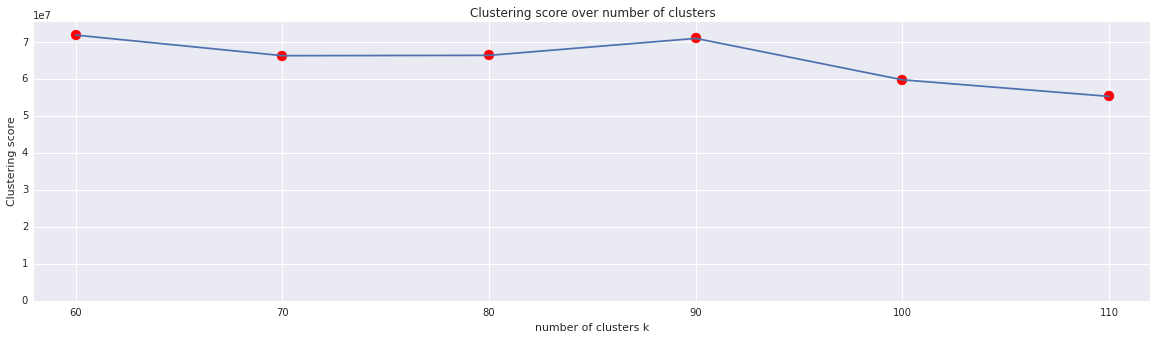

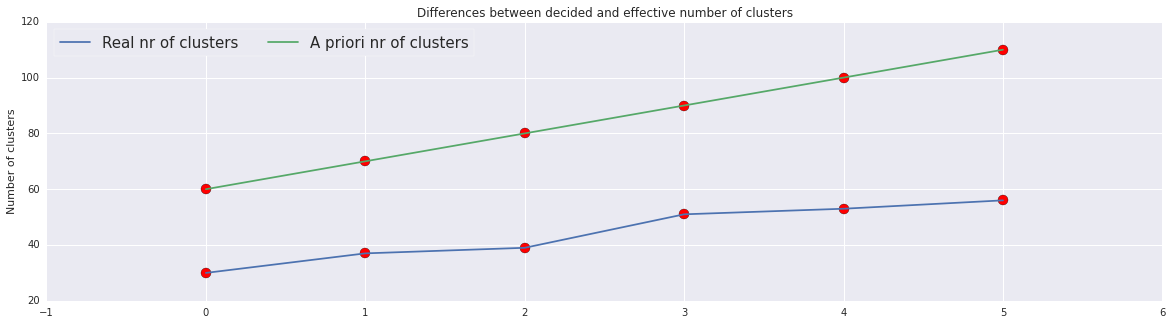

In [ ]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([58,112, 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

**Observations:**
- WSSSE dropped consistently as we increased k.
- Effective number of clusters decreases exponentially.

## Compare Loss Results with and without Normalization

In [ ]:
# let's use k as the best in the previous question = 80
clusters = KMeans.train(normalizedData, k=80, maxIterations=10, runs=10, initializationMode="random")

# get three axis on the first three attributes
sampledNormalized = normalizedData.sample(withReplacement=False, fraction=0.01)
datax_norm = sampledNormalized.map(lambda x: x[0]).collect()
datay_norm = sampledNormalized.map(lambda x: x[1]).collect()
dataz_norm = sampledNormalized.map(lambda x: x[2]).collect()
labels_norm = sampledNormalized.map(lambda x: clusters.predict(x)).collect()

# let's do also pca to see the difference
vectorData = normalizedData.map(Vectors.dense)
PCAModel = PCAmllib(3).fit(vectorData)
pcaData = PCAModel.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

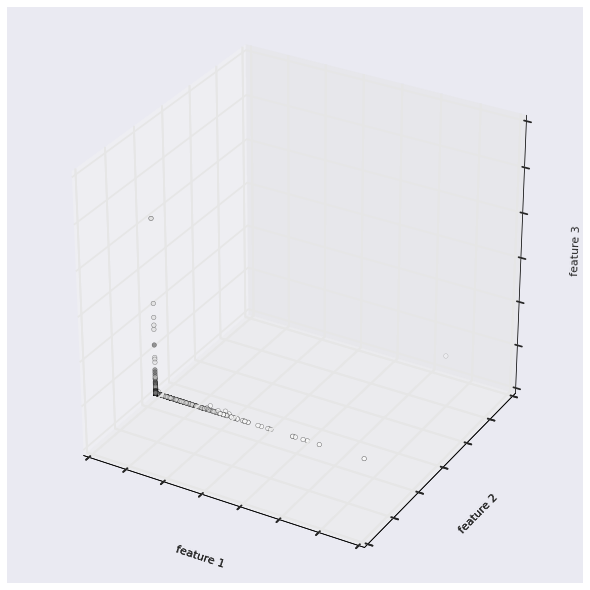

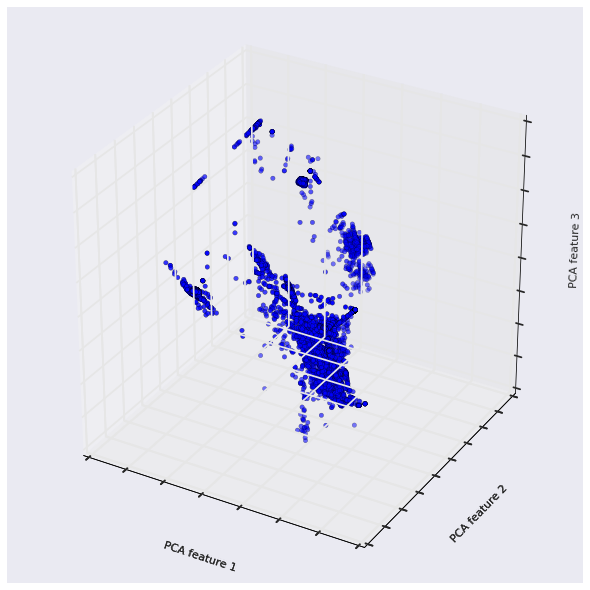

In [ ]:
# plot 
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter(datax_norm, datay_norm, dataz_norm, c=labels_norm)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

#pca plot
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter([x[0] for x in pcaData], [x[1] for x in pcaData], [x[2] for x in pcaData])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')

plt.show()

**Observations:**
- Normalizing values allowed a more standard variance for the different attributes and we can see the improvements in both plots.

- If we look side by side at this plot and at the PCA plot in question 3, we can see that thanks to data normalization, the data is spread more equally on the different principal components. We can see that the data is not packed together like it was before and so this may improve our anomaly detection thanks to a better division of clusters.

## 2.3. Clustering using Categorical Features

### Loading data
K-means only work with data points in a metric space. So, to use categorical features, we will transform each of them into one or more numerical features. 

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. 
However, by using this method, we implicitly assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true. In short, the numerical values will not reflect the actual meaning of categorical variable's value.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [ ]:
feat1 = raw_data.map(lambda x : x.split(",")[1]).distinct().collect()
feat2 = raw_data.map(lambda x : x.split(",")[2]).distinct().collect()
feat3 = raw_data.map(lambda x : x.split(",")[3]).distinct().collect()

In [ ]:
print("feature 1: length = %d\nfeatures = \n%s\n" %(len(feat1), feat1))
print("\nfeature 2: length = %d\nfeatures = \n%s\n" %(len(feat2), feat2))
print("\nfeature 3: length = %d\nfeatures = \n%s\n" %(len(feat3), feat3))

feature 1: length = 3
features = 
['udp', 'tcp', 'icmp']


feature 2: length = 70
features = 
['whois', 'pop_3', 'harvest', 'uucp_path', 'other', 'systat', 'ecr_i', 'vmnet', 'kshell', 'time', 'Z39_50', 'name', 'http', 'tftp_u', 'netbios_dgm', 'remote_job', 'ftp', 'domain_u', 'discard', 'ldap', 'eco_i', 'finger', 'http_2784', 'private', 'printer', 'sql_net', 'sunrpc', 'nnsp', 'iso_tsap', 'pop_2', 'exec', 'urp_i', 'daytime', 'netbios_ns', 'IRC', 'ftp_data', 'urh_i', 'http_443', 'bgp', 'domain', 'ctf', 'hostnames', 'mtp', 'netstat', 'login', 'klogin', 'nntp', 'ssh', 'imap4', 'aol', 'efs', 'X11', 'csnet_ns', 'rje', 'smtp', 'telnet', 'tim_i', 'shell', 'http_8001', 'supdup', 'red_i', 'pm_dump', 'courier', 'echo', 'ntp_u', 'netbios_ssn', 'uucp', 'gopher', 'auth', 'link']


feature 3: length = 11
features = 
['SH', 'OTH', 'S1', 'S2', 'REJ', 'RSTOS0', 'RSTO', 'S0', 'RSTR', 'S3', 'SF']



<div class="alert alert-success">
Let's plot the data and see how this categorical features split the data.
</div>

In [ ]:
f1 = raw_data.map(lambda x : x.split(",")[1]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f2 = raw_data.map(lambda x : x.split(",")[2]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f3 = raw_data.map(lambda x : x.split(",")[3]).map(lambda x : (x, 1)).reduceByKey(add).collect()

f1.sort(key=lambda x : x[1], reverse=True)
f2.sort(key=lambda x : x[1], reverse=True)
f3.sort(key=lambda x : x[1], reverse=True)

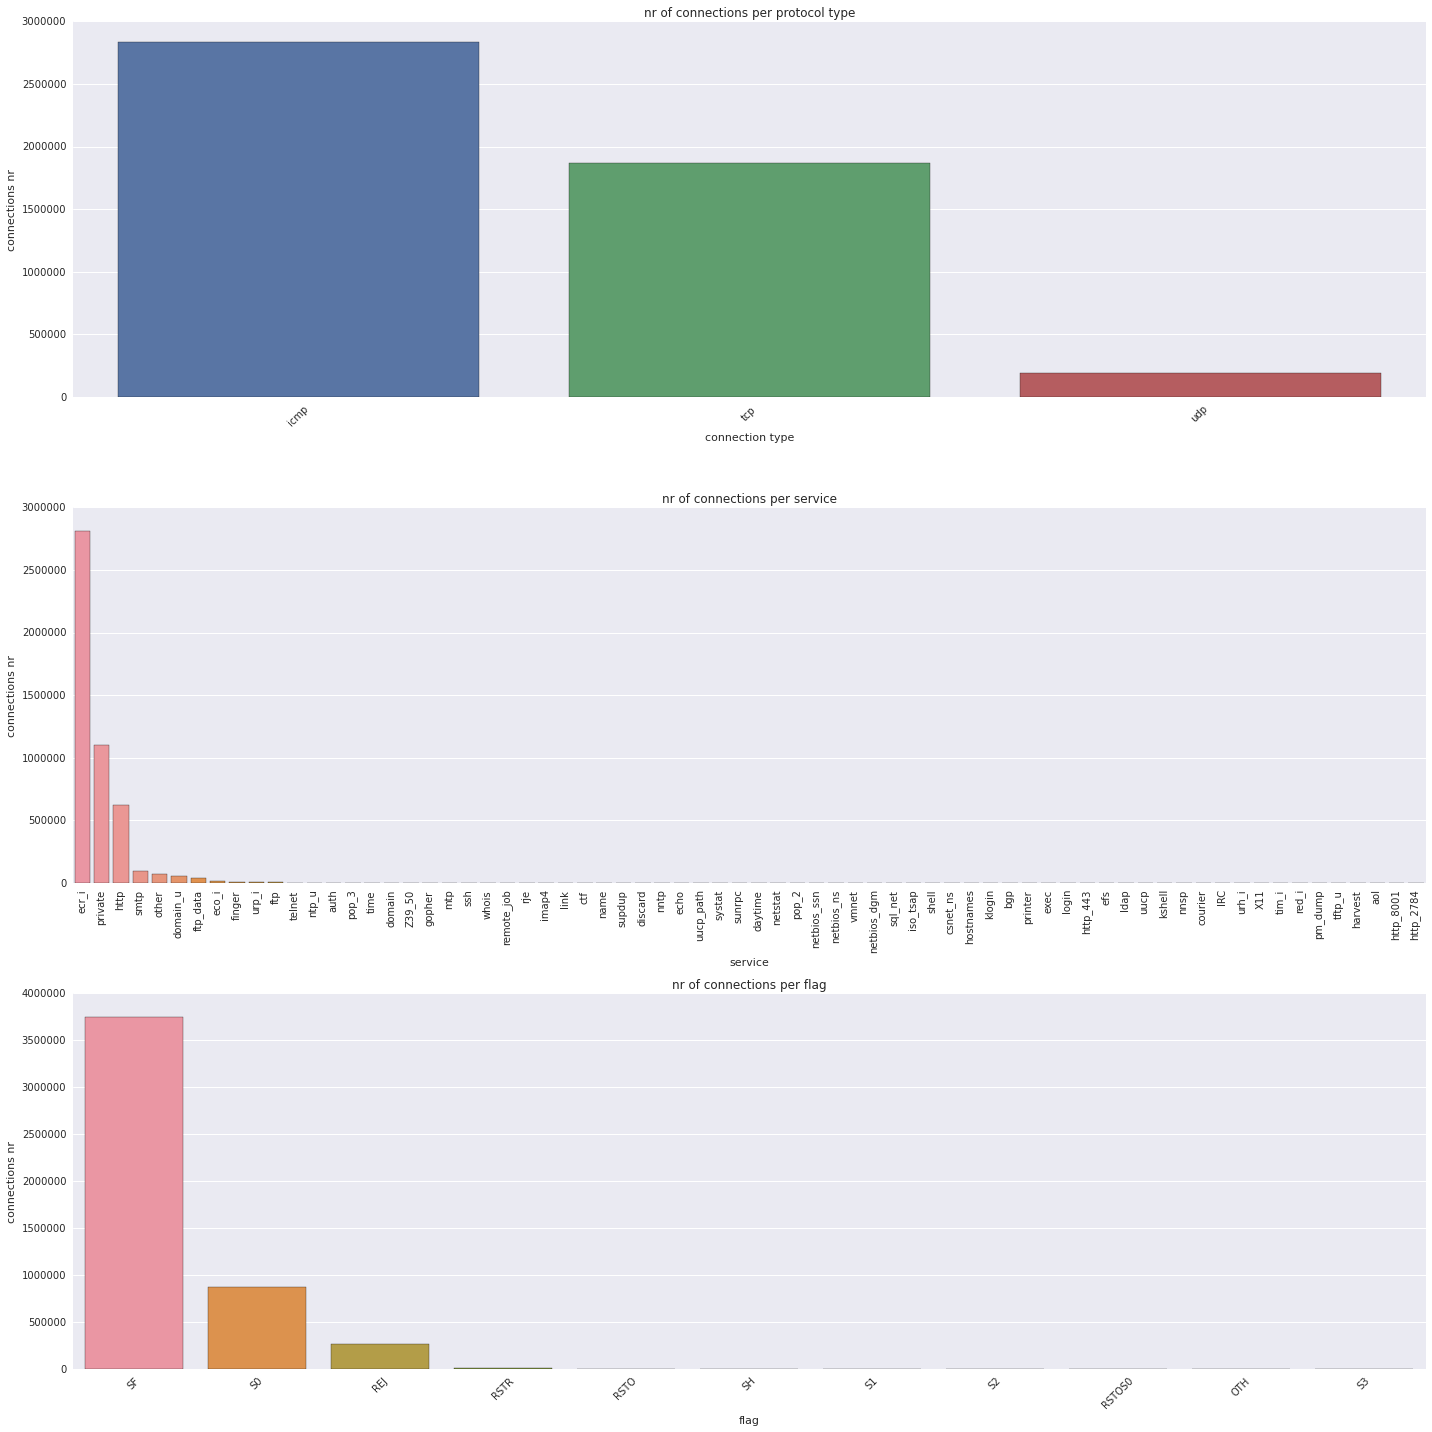

In [ ]:
# plotting
a = plt.figure(figsize=(20,20))
plt.subplot(311)
sns.barplot(x=np.arange(len(f1)), y=[_[1] for _ in f1])
plt.xticks(np.arange(len(f1)), [_[0] for _ in f1], rotation=45)
plt.title("nr of connections per protocol type")
plt.xlabel("connection type")
plt.ylabel("connections nr")

plt.subplot(312)
sns.barplot(x=np.arange(len(f2)), y=[_[1] for _ in f2])
plt.xticks(np.arange(len(f2)), [_[0] for _ in f2], rotation="vertical")
plt.title("nr of connections per service")
plt.xlabel("service")
plt.ylabel("connections nr")

plt.subplot(313)
sns.barplot(x=np.arange(len(f3)), y=[_[1] for _ in f3])
plt.xticks(np.arange(len(f3)), [_[0] for _ in f3], rotation=45)
plt.title("nr of connections per flag")
plt.xlabel("flag")
plt.ylabel("connections nr")

plt.tight_layout()

plt.show()

**Observations:** 
- The first attribute describes the connection type and can take 3 values, tcp, udp and icmp. The data is almost equally divided between icmp and tcp, leaving less than 50 thousand connections to udp.
- The second attribute describes the service and the third attribute describes the flags. As we can see, unfortunately, both this attributes concentrate much of the data in just 3 or 4 labels out of the 70, for the second attribute, and 11, for the third attribute.
We wrote <i>unfortunately</i> because having a not-so-distributed division of the data make us think that the clustering will not improve that much leaving the data as packed as before.

In [ ]:
def parseLineWithHotEncoding(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = [0]*len(feat1)
    featureOfCol1[feat1.index(vector[1])] = 1
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = [0]*len(feat2)
    featureOfCol2[feat2.index(vector[2])] = 1
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = [0]*len(feat3)
    featureOfCol3[feat3.index(vector[3])] = 1
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
#data = labelsAndData.values().cache()

#with our normalizeData function, we can simply do:
labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x:x[1]).cache()

### 2.3.2. Building models

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

In [ ]:
k_vector = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =  20, (effective nr. of clusters =  14) WSSSE = 435035506
k =  30, (effective nr. of clusters =  16) WSSSE = 436673060
k =  40, (effective nr. of clusters =  26) WSSSE = 392159586
k =  50, (effective nr. of clusters =  23) WSSSE = 391542154
k =  60, (effective nr. of clusters =  33) WSSSE = 359513808
k =  70, (effective nr. of clusters =  34) WSSSE = 375972806
k =  80, (effective nr. of clusters =  44) WSSSE = 333023705
k =  90, (effective nr. of clusters =  50) WSSSE = 321442614
k = 100, (effective nr. of clusters =  58) WSSSE = 306675359
k = 110, (effective nr. of clusters =  49) WSSSE = 321356507
k = 120, (effective nr. of clusters =  59) WSSSE = 294232881
k = 130, (effective nr. of clusters =  57) WSSSE = 299496956
k = 140, (effective nr. of clusters =  81) WSSSE = 279224531
k = 150, (effective nr. of clusters =  70) WSSSE = 309188678
k = 160, (effective nr. of clusters =  74) WSSSE = 290637292


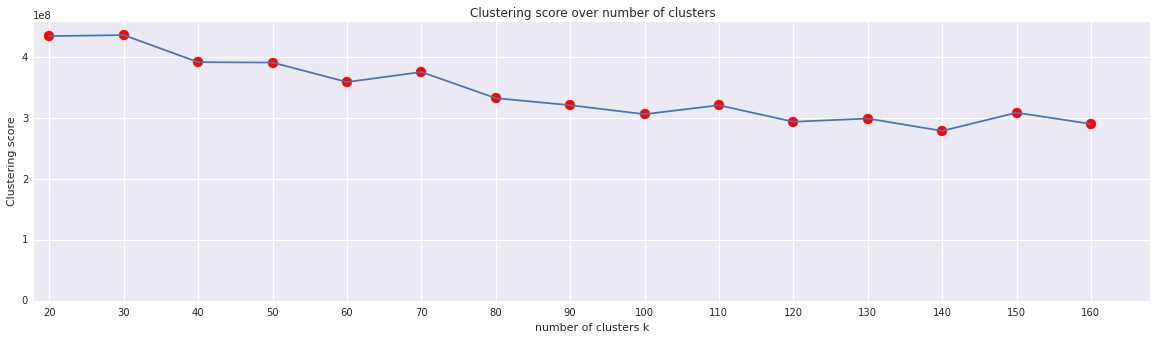

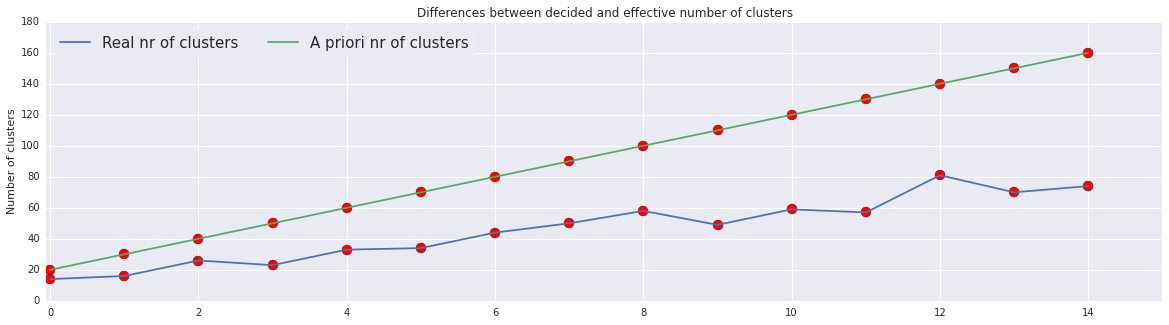

In [ ]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([18, 1.05*np.max(k_vector), 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
plt.xlim([-0.05, np.max(len(k_vector))])
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

**Observations**

- As we can see, the clustering score improves as $k$ increases, but remains almost the same from k=100 onwards. 
- Just like we observed previously, effective value of clusters decreases exponentially as we increase k.

## Using Model for Anomaly detection
We can use our model to find a anomalous connection. For each new connection, we can measure the new data point's distance to its nearest centroid. If this distance exceeds some thresholds, we can label it is anomalous.

In [ ]:
# choosing k=90 for clustering
bestK = 90

In [ ]:
clusters = KMeans.train(normalizedData, bestK, maxIterations=10, runs=10, initializationMode="random")

In [ ]:
print("Initial k clusters:", bestK)
print("Effective clusters:", len(clusters.centers))

Initial k clusters: 90
Effective clusters: 39


### Finding Appropriate Threshold
How do we decide the threshold? We can look into distances of dataset points from the centroids and decide appropriate threshold.

In [ ]:
ordered = normalizedData.map(lambda x : (error(clusters, x), x)).takeOrdered(10000, lambda key : -key[0])

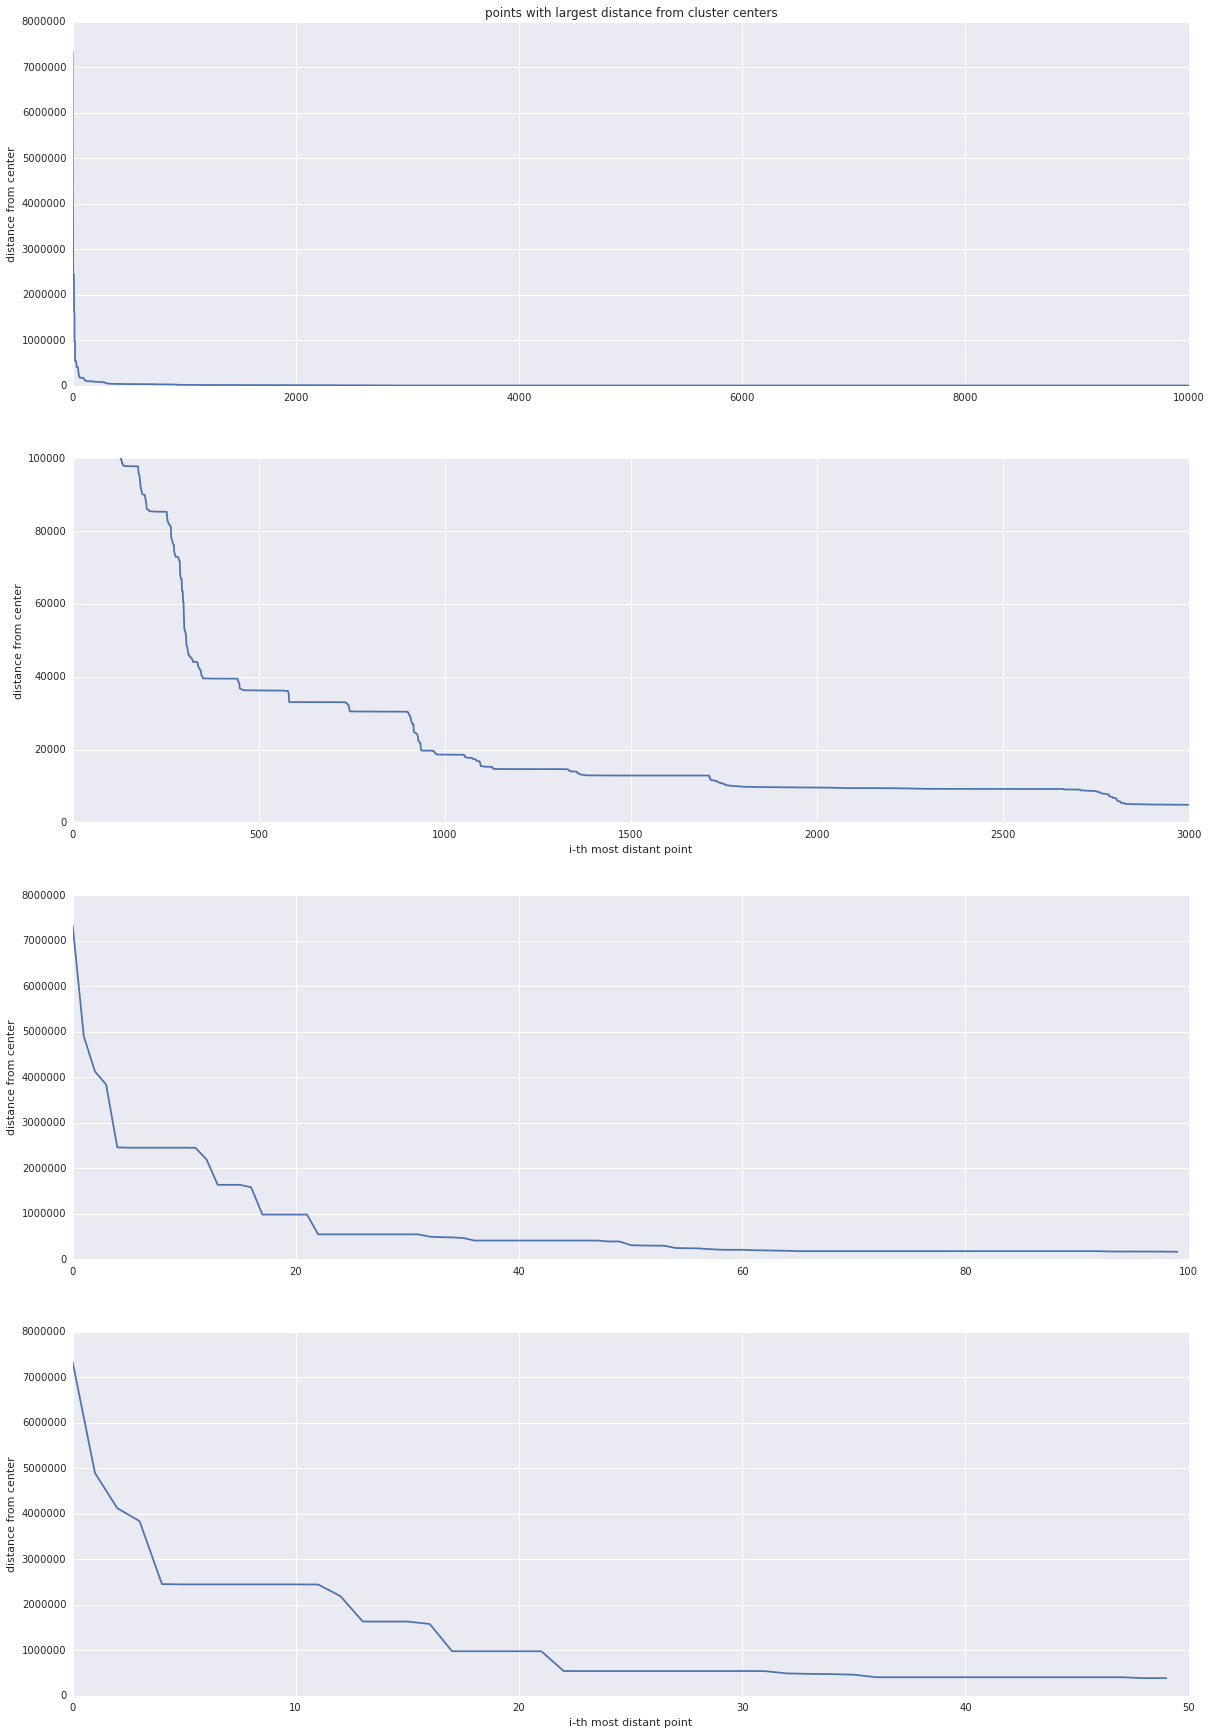

In [ ]:
xx = [x[0] for x in ordered]
plt.figure(figsize=(20,30))
plt.subplot(411)
plt.plot(xx)
plt.title("points with largest distance from cluster centers")
plt.ylabel("distance from center")

plt.subplot(412)
plt.plot(xx[:3000])
plt.ylabel("distance from center")
plt.xlabel("i-th most distant point")
plt.ylim(0,100000)

plt.subplot(413)
plt.plot(xx[:100])
plt.ylabel("distance from center")

plt.subplot(414)
plt.plot(xx[:50])
plt.ylabel("distance from center")
plt.xlabel("i-th most distant point")
plt.show()

**Observations:**
- The first plot shows the 10000 points with the largest distance from the cluster. As we can see, **after an initial peak of 30** (probably the anomalous connections), the distance from the cluster tends to get smaller. This means that the majority of the clusters are packed up together and the outliers could be easily detected.

- The second plot is a zoom in of just the bottom part (with a limit on the y range) and we can see that actually zooming in, the plot continues to slope down until 2400-2500 connections and then stays to a "small" distance for the rest of the plot.

- The next two plots are just a zoom in on the top-100 and top-50 furthest connections.

- Other than the first plot, this zoom-in allow us to decide which is the best threshold to use to divide anomalous connections from the normal ones.

- As we can see, the first 20/30 points span a distance from 1 million to 7 million, and considering the first 2500 points (remember that the full dataset is 5 million points so 2500 points is just 0.05%) the distance drops from 7 million to almost 5000. This number alone doesn't say a lot, since to evaluate the error the distance is squared, but noticing that after that slope the distance is almost constant makes us think to put that number as threshold.

We can try to plot the nr of anomalous connections per threshold to have a better idea:


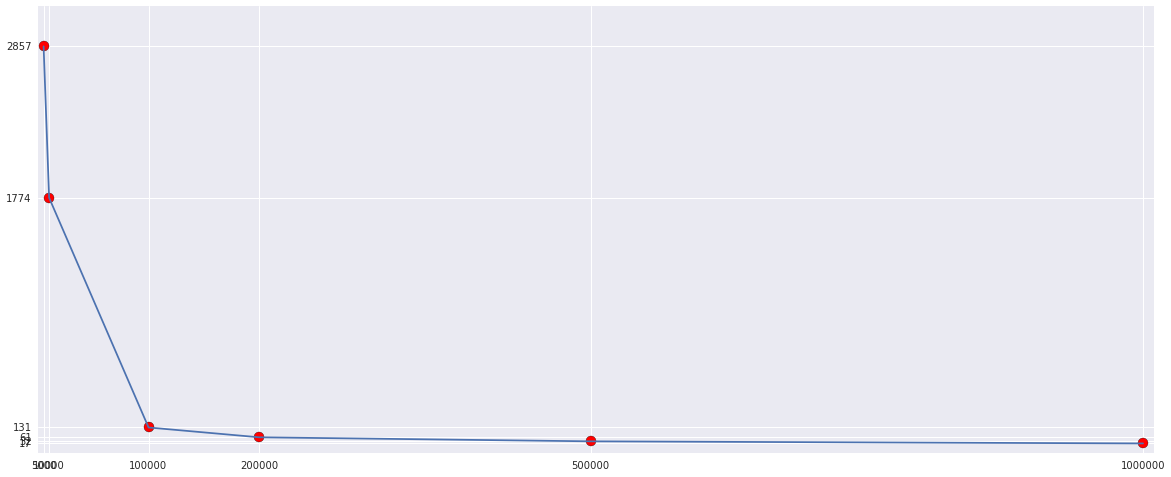

Threshold:    1000000	anomalous connections:    17
Threshold:     500000	anomalous connections:    32
Threshold:     200000	anomalous connections:    61
Threshold:     100000	anomalous connections:   131
Threshold:      10000	anomalous connections:  1774
Threshold:       5000	anomalous connections:  2857


In [ ]:
thresholds = [1000000, 500000, 200000, 100000, 10000, 5000]
t_count = [len([__ for __ in xx if __ > _]) for _ in thresholds]

plt.figure(figsize=(20,8))
plt.scatter(thresholds, t_count, c="r", s=100)
plt.plot(thresholds, t_count)
plt.yticks(t_count)
plt.xticks(thresholds)
plt.ylim(-50, np.max(t_count)*1.1)
plt.xlim(0, np.max(thresholds)*1.01)
plt.show()

for i in range(len(thresholds)):
    print("Threshold: %10d\tanomalous connections: %5d" %(thresholds[i], t_count[i]))

**Observations:**
This plot shows the number of connections we would label as anomalous if we would select a certain threshold. As obvious, increasing the threshold will determine less anomalous connections.

### Checking Groundtruth Labels of Anamlous Connections
#### Using threshold of 5000 to filter out maximum possible anomalous connections.

In [ ]:
currThre = 5000
y = labelsAndDataNorm.map(lambda x : (x[0], error(clusters, x[1]))).filter(lambda x: x[1]>currThre) \
                    .map(lambda x : (x[0], 1)).reduceByKey(add).collect()

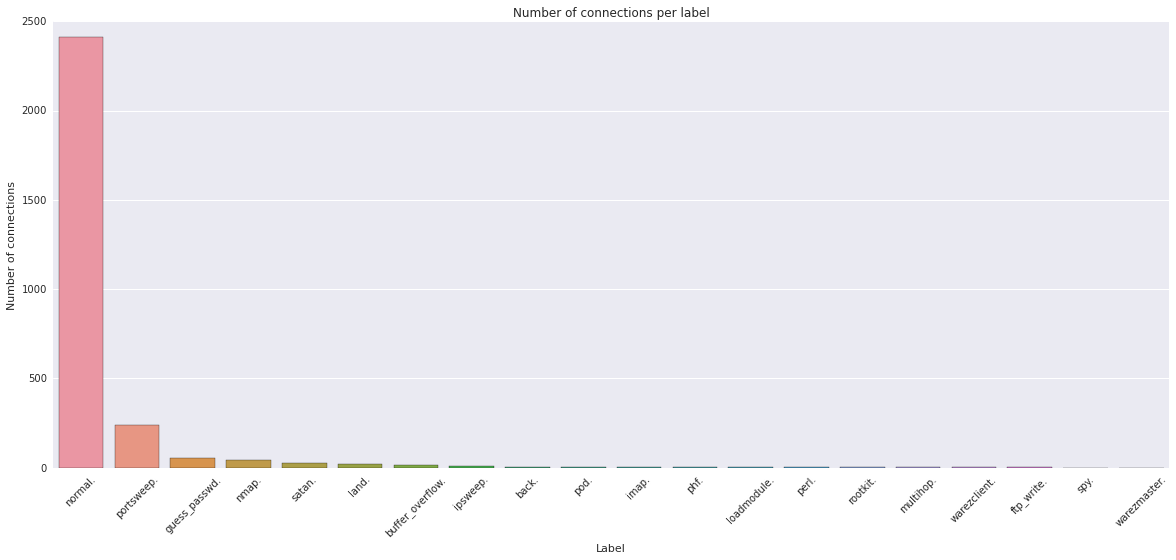

In [ ]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

**Observations:** 
- It's interesting to see that of the almost 3 thousand anomalous connections, almost 2500 are labelled as normal.
- We expected a result similiar to this one. <b><i>Why?</i></b> Because all the other labels are <i>known</i> attacks and in our opinion an anomaly is a connection different to all the other ones already seen like, for example, a new type of attack, an unknown error, a strange traffic... In our opinion, a <code>guess_passwd</code> attack or a <code>buffer_overflow</code> attack is known and traffic analyst know how to recognize it instead, a model like this one should be used to allow them to recognize <i>new</i> type of dangers. And this is why, since this should be <i>unknown</i> dangers that the system doesn't know how to label, in our opinion are all labelled as <code>normal</code> connection.

#### Using threshold of 10000 to explore the changes

In [ ]:
currThre = 100000
y = labelsAndDataNorm.map(lambda x : (x[0], error(clusters, x[1]))).filter(lambda x: x[1]>currThre) \
                    .map(lambda x : (x[0], 1)).reduceByKey(add).collect()

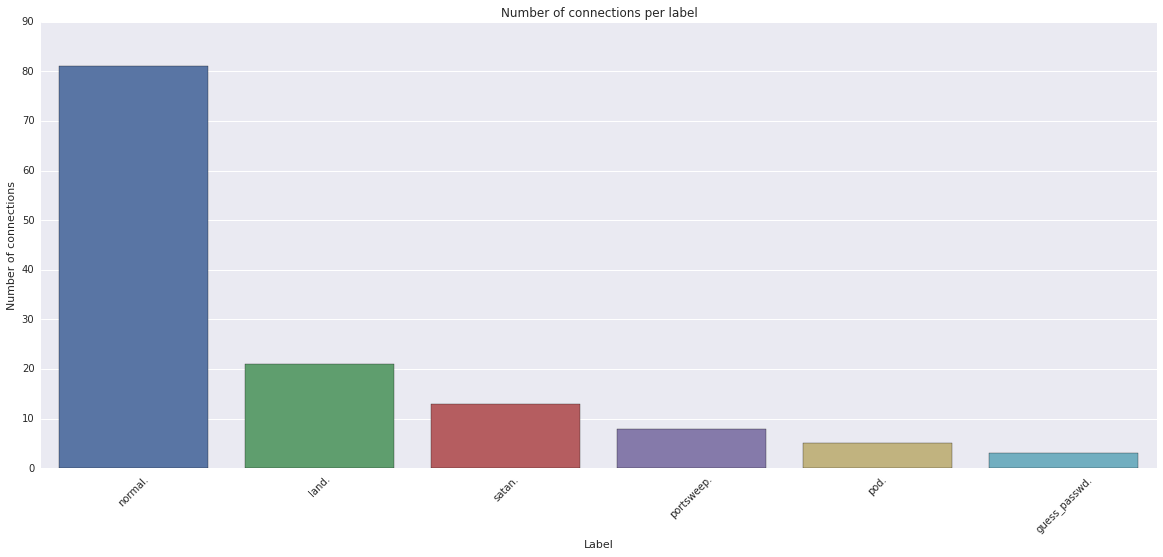

In [ ]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

We increased the threshold up to a point where only 131 anomalies would be detected.

As we can see, the <code>normal</code> label is still the most present one, giving a hint that our reasoning in observations written above might be correct.

-----

## Conclusion
- KNN clustering could be used to pinpoint potential anamalous connections being labeled as "normal" by other model(s). This will help security team to detect anomolies in network traffic and do further investigation to uncover new kinds of attacks.
- In production, KNN model could be used in parallel with another model able to predict which type of connections are happening (for instance, decision tree) that uses all the attributes to label the connections and recognize known attacks.